### Workbook for calculating the reflectivity of an anisotropic stratified media

In [1]:
#Package Initialization
#Refnx is used for structure generation and fitting routines
#Ani_Reflect_Model is the custom application for anisotropic media

%matplotlib inline

# start off with the necessary imports
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})

import refnx
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective
from refnx.reflect import SLD, Slab, ReflectModel
from refnx.reflect.ani_reflect_model import *

import time

##Define constants that will be used later
hc = 1239.84193 ##ev*nm|
c = 299792458.
mu0 = 4. * np.pi * 1e-7
ep0 = 1. / (c**2 * mu0)

In [2]:
# what is the refnx version
print(refnx.version.version)

0.1.11


#### Import Dataset here if intersted in fitting

In [3]:
data = ReflectDataset('Thelen_250eV.txt')

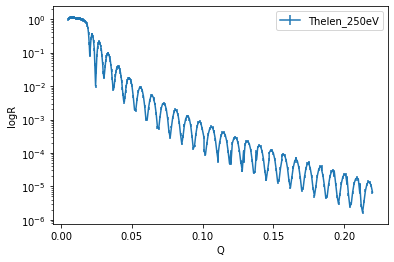

In [4]:
#Quick plot to verify data
data.plot()
plt.legend()
plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()

### Generate dielectric tensor components for slab assignment

#### Isotropic, Uniaxial, and Biaxial (unconfirmed) are supported

#### TO DO LIST ~~
    1) Generate tensors directly from CXRO database by giving it an energy 
        Look into 'Periodic Table' package for strategy
        May want to convert to dielectric constant in the model function so inputs can be in delta & beta
    
    2) Generate tensors directly from input file for organic molecules
        From a NEXAFS spectra of nxx, nyy, nzz calculate the input tensor
        This will be useful for inital fit inputs and modeling

In [5]:
##Create anisotropic tensors
####inputs must be a diagonal 3x3 numpy array.

Silicon_epsilon = (0.98805666 + 1j*0.008500482)  * np.eye(3) #From CXRO @ 250eV
SiO2_epsilon = (0.988016631 + 1j*0.00463295) * np.eye(3) #From CXRO @ 250eV
#SiO2_epsilon = (1.002 + 1j*0) * np.eye(3) #From CXRO @ 250eV

Pos_epsilon = (0.994527941 + 1j*0.000375501) * np.eye(3)
Air_epsilon = np.eye(3)

epsilon_1_xx = (1.008 + 1j*0.008)
epsilon_1_zz = (1.014 + 1j*0.004) 

epsilon_1 = np.diag([epsilon_1_xx,epsilon_1_xx,epsilon_1_zz])# * ep0


delta_PS = 3.45346848E-06
beta_PS = 4.89482366E-09
e_PS = np.complex(1-2*delta_PS,2*beta_PS)
delta_Si = 7.57536282E-06
beta_Si = 1.72802345E-07
n_Si = np.complex(1-2*delta_Si, 2*beta_Si)

PS_eps = np.diag([e_PS,e_PS,e_PS])
Si_eps = np.diag([n_Si,n_Si,n_Si])


#### Create SLD objects that house the dielectric tensor

In [6]:
#Generate SLDs

Silicon = SLD(Silicon_epsilon, name='Si')
SiO2 = SLD(SiO2_epsilon, name='SiO2')
Pos = SLD(Pos_epsilon, name='POS')
Air = SLD(Air_epsilon, name="Air")

Si_10k = SLD(Si_eps, name='Si10K')
PS_10K = SLD(PS_eps,name='PS10k')

#### Create 'slab' objects that represent a layer in the model

'slab' = 'SLD'(thickness, roughness)

    --Substrate thickness can be any value (not used in calculation) 
    --Roughness corresponds to the top of the layer, I.E. The side closest to the superstrate
    --Superstrate is not assigned through a 'slab' ~~See structure generation

In [62]:
# Generate Slabs
# Slab objects are created from SLD objects in this way
#Create layer for Posaconozole
Pos_layer = Pos(720, 6)
sio2_layer = SiO2(10,2)
substrate = Silicon(0,0.01)

PS_slab = PS_10K(800,0)
sub_10k = Si_10k(100,0)


#### Assign fitting parameters

    --default is to remain constant
    
##### List of parameters ~
    .thick -> Layer thickness
    .rough -> Layer roughness
    .sldAvg -> Trace of dielectric tensor (real)
    .isldAvg -> Trace of dielectric tensor (imaginary)
    .sldxx -> xx component of tensor (real)
    .isldxx -> xx component of tensor (imaginary)
    .sldyy -> yy component of tensor (real)
    .isldyy -> yy component of tensor (imaginary)
    .sldzz -> zz component of tensor (real)
    .isldzz -> zz component of tensor (imaginary)

In [63]:
##Check Parmaeters
#print(Pos_layer)

#### TO DO List ~~
    1) Figure out how constraints can be applied to the parameters
        --Ex. constant trace but let components vary
        --Constant total thickness but let individual layers vary

In [64]:
sio2_layer.thick.setp(bounds=(10, 15), vary=True)
sio2_layer.rough.setp(bounds=(3, 5), vary=True)

Pos_layer.thick.setp(bounds=(720, 740), vary=True)
Pos_layer.rough.setp(bounds=(5, 10), vary=True)
Pos_layer.sld.xx.setp(bounds=(0.95, 1), vary=False)
Pos_layer.sld.yy.setp(bounds=(0.95, 1), vary=False)
Pos_layer.sld.zz.setp(bounds=(0.95, 1), vary=False)
Pos_layer.sld.izz.setp(bounds=(0.95, 1), vary=False)

substrate.rough.setp(bounds=(0,1),vary=True)

#### Generate the structure object

'structure' = superstrate (sld) | top layer (slab) | ... | bottom layer (slab) | substrate (slab)

In [65]:
structure = Air | Pos_layer |sio2_layer | substrate
#structure = Air  | PS_slab | sub_10k

#### Plot SLD Profile
    Quick visualization of SLD profile
    Plots sldAvg (real) as a function of depth

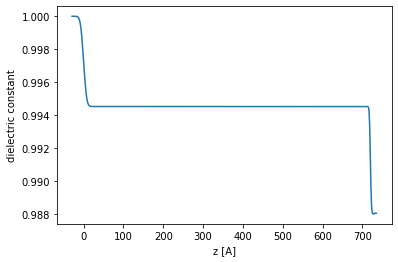

In [66]:
#plot results
plt.plot()
plt.plot(*structure.sld_profile())
plt.ylabel('dielectric constant')
plt.xlabel('z [A]')
plt.show()

### Setup scattering model

    Inputs
        scale  - multiplicative scale
        bkg    - additive background
        dq     - gaussian q smearing
        Energy - List of energies as a numpy array (only 1 unless simulating)

In [67]:
# a ReflectModel is made from the Structure.
# ReflectModel calculates smeared reflectivity, applies scaling factor and background
Energy = np.array([250])
model = ReflectModel(structure, scale=1,bkg=0,dq=0,Energy=Energy)

model.scale.setp(bounds=(0.6, 1.2), vary=False)
model.bkg.setp(bounds=(1e-9, 9e-6), vary=False)

#### Simulate scattering
    Inputs
        qvals

In [70]:
qvals = np.linspace(0.005,0.25,200)

start_time = time.time()
TestModelR  = model.model(qvals) #TestModelT
time_elapsed = time.time() - start_time
print('Calculation took', time_elapsed, 'seconds')

Calculation took 0.8696713447570801 seconds


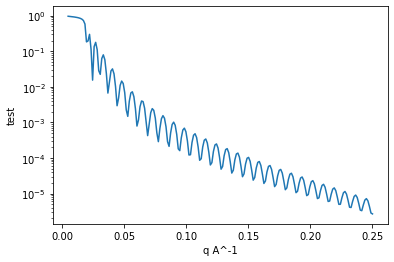

In [71]:
#plot Reflectivity
plt.plot()
plt.yscale('log')
plt.plot(qvals,TestModelR)
plt.ylabel('test')
plt.xlabel('q A^-1')
plt.show()

Make an Objective

In [72]:
objective = Objective(model, data, transform=Transform('logY'))

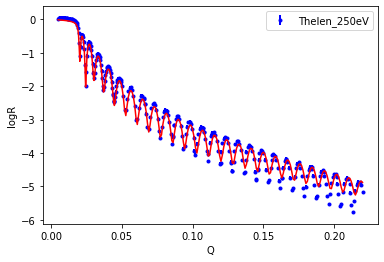

In [73]:
# an Objective has a plot method, which is a quick visualisation. You need
# matplotlib installed to create a graph
objective.plot()
plt.legend()
plt.xlabel('Q')
plt.ylabel('logR')
plt.legend()

In [ ]:
start_time = time.time()
# CurveFitters do the fitting/sampling
fitter = CurveFitter(objective)

# do an initial fit with differential evolution
res = fitter.fit('differential_evolution')
time_elapsed = time.time() - start_time
print('Calculation took', time_elapsed, 'seconds')

#### Calculate EFI of final structure

In [42]:
z,E,zloc = model.EFI(qvals,dz=1)

(4, 4, 1000, 1)
(4, 3, 4, 1000, 1)
[730. 730. 720.   0.]


In [43]:
absE = (np.abs(E[0,:,:,0])**2 + np.abs(E[1,:,:,0])**2 + np.abs(E[2,:,:,0])**2)/3

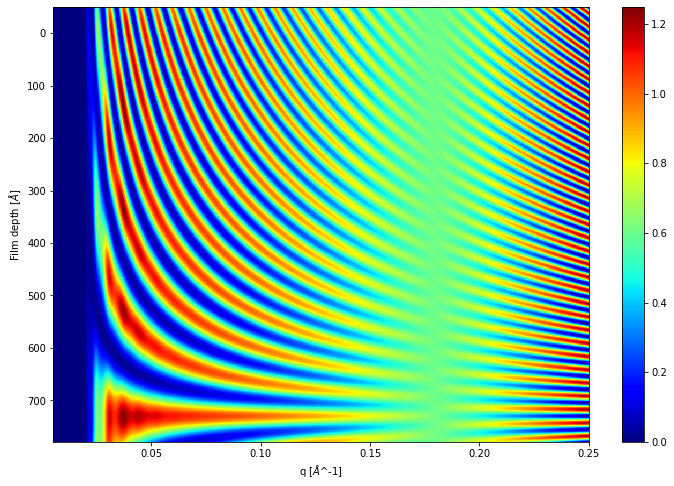

In [53]:
#plt.subplots_adjust(bottom=0)
#theta = (np.arcsin((qvals[:]*1.54)  / (4*np.pi))) * 180/np.pi
plt.figure(figsize=(12,8))
E1 = plt.imshow(absE,cmap='jet',aspect='auto',extent=[qvals[0],qvals[-1],z[-1],z[0]])

plt.xlabel('q [$\AA$^-1]')
plt.ylabel('Film depth [$\AA$]')
ECB = plt.colorbar(E1)
#ECB.ax.set_ylabel('E Field Strength',rotation=270)
#plt.xlim(0.15,0.2)
# ax[0].set_xlabel(r'$\alpha_i$ [Degrees]')


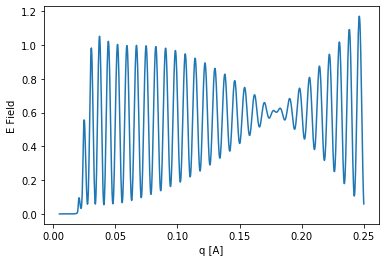

In [59]:
#plot results
plt.plot()
plt.plot(qvals,absE[0,:])#,qvals,absE[0,:])
plt.ylabel('E Field')

plt.xlabel('q [A]')
plt.show()